In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('temp_df_final.csv', index_col = 0).iloc[:, 1:]

df2 = pd.read_csv('Add_TI_섹터ETF/KODEX_2차전지산업_TI.csv', index_col = 0)

In [2]:
# Converting 'stateDt' to datetime format
df['stateDt'] = pd.to_datetime(df['stateDt'], format='%Y%m%d')


# Renaming the 'stateDt' column to 'Date'
df.rename(columns={'stateDt': 'Date'}, inplace=True)


df.tail()  # Display the last few rows to check the changes


,Date,decideCnt,deathCnt
1106,2023-04-15,30978954.0,34368.0
1107,2023-04-17,30994088.0,34376.0
1108,2023-04-18,31009261.0,34386.0
1109,2023-04-19,31025769.0,34392.0
1110,2023-04-20,31039863.0,34401.0


In [3]:


# '날짜'와 '종가' 컬럼 이름 변경
df2.rename(columns={'날짜': 'Date', '종가': 'Close'}, inplace=True)
df2['Date'] = pd.to_datetime(df2['Date'], format='%Y-%m-%d')
df2['diff_1'] = df2['Close'].pct_change()





df2.head()  # 변경된 데이터프레임의 마지막 몇 행을 확인합니다.


,Date,Close,diff_5,diff_20,ma_5,ma_20,diff_1
1119,2019-09-05,7900.0,0.016731,0.054740,7874.0,7765.25,NaN
1118,2019-09-06,7885.0,-0.004419,0.036137,7867.0,7779.00,-0.001899
1117,2019-09-09,7820.0,-0.003822,0.018893,7861.0,7786.25,-0.008244
1116,2019-09-10,7790.0,-0.007643,0.011032,7849.0,7790.50,-0.003836
1115,2019-09-11,7875.0,0.003185,0.041667,7854.0,7806.25,0.010911


In [4]:
# df에서 decideCnt와 deathCnt의 차이를 계산하고, 이를 %로 변환
df['decideCnt_diff'] = df['decideCnt'].diff().fillna(0)
df['deathCnt_diff'] = df['deathCnt'].diff().fillna(0)
df['decideCnt_diff_perc'] = df['decideCnt_diff'] / df['decideCnt'].shift(5)
df['deathCnt_diff_perc'] = df['deathCnt_diff'] / df['deathCnt'].shift(5)
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # 무한대 값을 NaN으로 대체

# df2와 df를 'Date' 기준으로 합치기
df_combined = pd.merge(df2, df[['Date', 'decideCnt_diff_perc', 'deathCnt_diff_perc']], on='Date', how='outer')

# NaN이 포함된 행 제거
df_combined.dropna(inplace=True)

df_combined.tail()

,Date,Close,diff_5,diff_20,ma_5,ma_20,diff_1,decideCnt_diff_perc,deathCnt_diff_perc
891,2023-04-14,30380.0,0.040411,0.221307,30173.0,27868.50,0.029656,0.000377,0.000146
892,2023-04-17,31325.0,0.026376,0.267449,30334.0,28199.00,0.031106,0.000489,0.000233
893,2023-04-18,31435.0,0.020286,0.264227,30459.0,28527.50,0.003512,0.000490,0.000291
894,2023-04-19,31935.0,0.077066,0.245272,30916.0,28842.00,0.015906,0.000533,0.000175
895,2023-04-20,31350.0,0.062532,0.194513,31285.0,29097.25,-0.018318,0.000455,0.000262


In [5]:
df_combined



,Date,Close,diff_5,diff_20,ma_5,ma_20,diff_1,decideCnt_diff_perc,deathCnt_diff_perc
116,2020-02-27,8440.0,-0.091496,0.015644,8727.0,8932.00,-0.024277,1.166282,0.500000
117,2020-02-28,8055.0,-0.107973,-0.009225,8532.0,8928.25,-0.045616,0.948505,0.000000
118,2020-03-02,8280.0,-0.049369,0.004854,8446.0,8930.25,0.027933,0.377478,0.333333
119,2020-03-03,8330.0,-0.053947,-0.039216,8351.0,8913.25,0.006039,0.339751,0.461538
120,2020-03-04,8525.0,-0.014451,-0.028490,8326.0,8900.75,0.023409,0.220796,0.307692
...,...,...,...,...,...,...,...,...,...
891,2023-04-14,30380.0,0.040411,0.221307,30173.0,27868.50,0.029656,0.000377,0.000146
892,2023-04-17,31325.0,0.026376,0.267449,30334.0,28199.00,0.031106,0.000489,0.000233
893,2023-04-18,31435.0,0.020286,0.264227,30459.0,28527.50,0.003512,0.000490,0.000291
894,2023-04-19,31935.0,0.077066,0.245272,30916.0,28842.00,0.015906,0.000533,0.000175


In [98]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
from tqdm import tqdm 

# 예제 데이터 (Assuming df_combined is already defined)
# df_combined = pd.DataFrame({...}) 

windows = [753]
max_lags = {753: 120}

def optimal_lag(df_combined, window, max_lag):
    p_values_dict = {}
    # tqdm is used here to show progress
    for start in tqdm(range(len(df_combined) - window + 1), desc=f'Processing Window {window}'):
        sub_df_combined = df_combined.iloc[start:start + window]
        p_values = []
        
        print(f"\nWindow starting at index {start}:")
        
        for lag in range(1, max_lag + 1):
            result = grangercausalitytests(sub_df_combined[['diff_5', 'deathCnt_diff_perc']], maxlag=lag, verbose=False)
            p_value = result[lag][0]['ssr_ftest'][1]
            print(f"Lag {lag}: p-value = {p_value:.6f}")
            
            p_values.append(p_value)
        
        p_values_dict[start] = p_values
        
    return p_values_dict


Processing Window 753:   0%|          | 0/1 [00:00<?, ?it/s]


Window starting at index 0:
Lag 1: p-value = 0.442554
Lag 2: p-value = 0.373179
Lag 3: p-value = 0.514912
Lag 4: p-value = 0.016338
Lag 5: p-value = 0.001081
Lag 6: p-value = 0.006567
Lag 7: p-value = 0.001308
Lag 8: p-value = 0.000021
Lag 9: p-value = 0.000001
Lag 10: p-value = 0.000000
Lag 11: p-value = 0.000000
Lag 12: p-value = 0.000000
Lag 13: p-value = 0.000000
Lag 14: p-value = 0.000000
Lag 15: p-value = 0.000000
Lag 16: p-value = 0.000000
Lag 17: p-value = 0.000000
Lag 18: p-value = 0.000000
Lag 19: p-value = 0.000000
Lag 20: p-value = 0.000000
Lag 21: p-value = 0.000005
Lag 22: p-value = 0.000119
Lag 23: p-value = 0.001365
Lag 24: p-value = 0.002876
Lag 25: p-value = 0.010588
Lag 26: p-value = 0.095660
Lag 27: p-value = 0.219625
Lag 28: p-value = 0.338187
Lag 29: p-value = 0.401891
Lag 30: p-value = 0.404445
Lag 31: p-value = 0.542440
Lag 32: p-value = 0.559867
Lag 33: p-value = 0.584411
Lag 34: p-value = 0.608962
Lag 35: p-value = 0.693701
Lag 36: p-value = 0.797073
Lag 37: 

Processing Window 753: 100%|██████████| 1/1 [01:42<00:00, 102.74s/it]

Lag 120: p-value = 0.332732


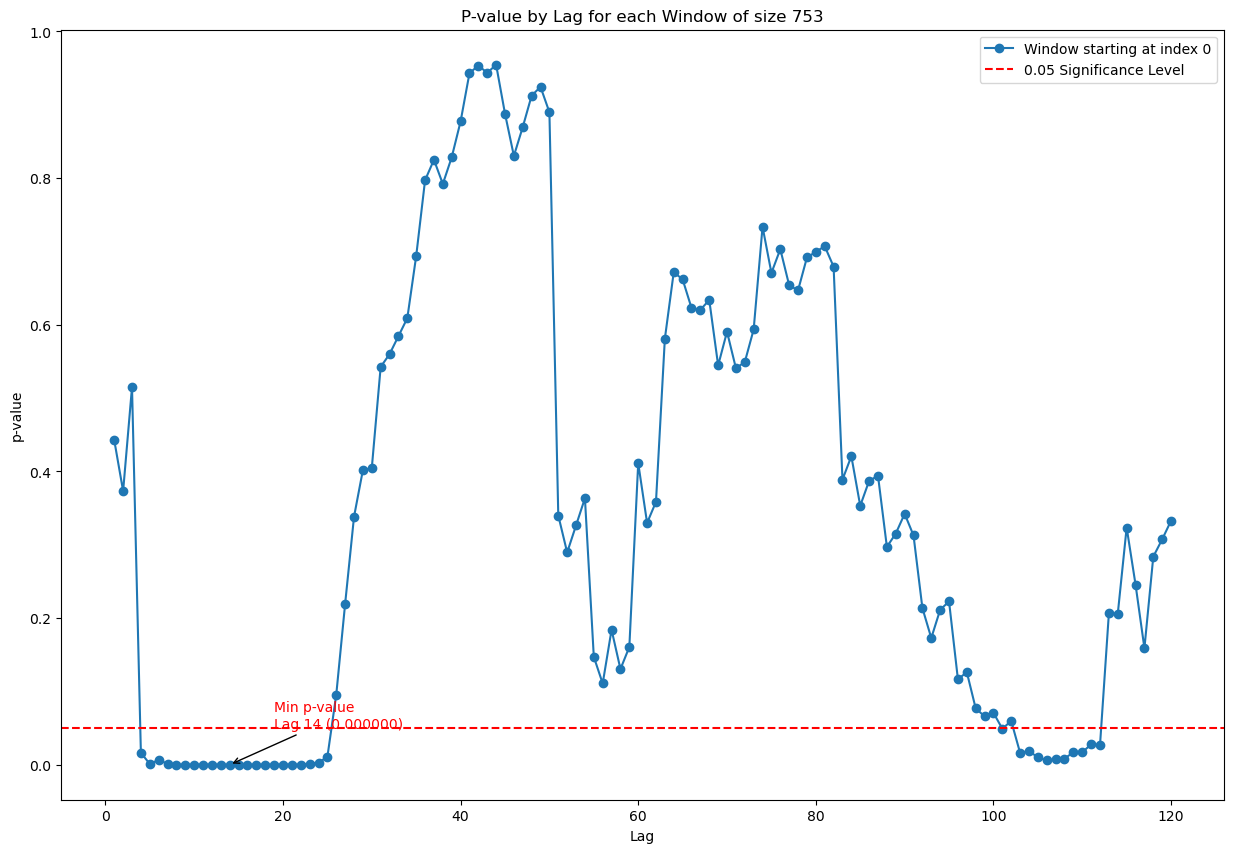

In [99]:
for window in windows:
    max_lag = max_lags[window]
    p_values_dict = optimal_lag(df_combined, window, max_lag)

    # 시각화
    plt.figure(figsize=(15, 10))
    
    for start, p_values in p_values_dict.items():
        plt.plot(range(1, max_lag + 1), p_values, marker='o', label=f'Window starting at index {start}')
        
        # p-value가 최소가 되는 지점 찾기
        min_p_value = min(p_values)
        min_lag = p_values.index(min_p_value) + 1
        
        # 그래프에 표시
        plt.annotate(f'Min p-value\nLag {min_lag} ({min_p_value:.6f})',
                     xy=(min_lag, min_p_value), xytext=(min_lag + 5, min_p_value + 0.05),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=10, color='red')

    plt.xlabel('Lag')
    plt.ylabel('p-value')
    plt.title(f'P-value by Lag for each Window of size {window}')
    plt.axhline(y=0.05, color='r', linestyle='--', label='0.05 Significance Level')
    plt.legend(loc='best')
    plt.show()